# --- Phase 4: Modeling & Evaluation ---  

This notebook focuses on building, training, and evaluating machine learning models to predict customer churn. It includes data splitting, model selection, performance evaluation using various metrics, basic hyperparameter tuning, and feature importance analysis to identify key churn drivers.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline

import joblib # For saving and loading models

# Set display options for better viewing of DataFrames and plots
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) # Default plot size

print("Libraries imported successfully!")

Libraries imported successfully!


# --- 1. Load Feature-Engineered Data ---

In [2]:
features_data_path = r'../data/processed/customer_churn_features.csv'

try:
    df_features = pd.read_csv(features_data_path)
    print(f"\nSuccessfully loaded feature-engineered data from {features_data_path}")
    print(f"Feature data shape: {df_features.shape}")
    print(df_features.info())
except FileNotFoundError:
    print(f"Error: Feature-engineered data file not found at {features_data_path}. Please ensure 02_feature_engineering.ipynb was run successfully.")
    df_features = pd.DataFrame() # Create empty DataFrame to prevent further errors
except Exception as e:
    print(f"An error occurred while loading feature data: {e}")
    df_features = pd.DataFrame()


Successfully loaded feature-engineered data from ../data/processed/customer_churn_features.csv
Feature data shape: (5281, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5281 entries, 0 to 5280
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             5281 non-null   int64  
 1   Monetary                5281 non-null   float64
 2   Frequency               5281 non-null   int64  
 3   Recency                 5281 non-null   int64  
 4   Tenure                  5281 non-null   int64  
 5   is_churned              5281 non-null   int64  
 6   Country_Belgium         5281 non-null   bool   
 7   Country_France          5281 non-null   bool   
 8   Country_Germany         5281 non-null   bool   
 9   Country_Netherlands     5281 non-null   bool   
 10  Country_Other           5281 non-null   bool   
 11  Country_Portugal        5281 non-null   bool   
 12  Country_Spain      

# --- 2. Prepare Data for Modeling ---

In [3]:
# Separate features (X) and target variable (y)
# The 'Customer ID' column is an identifier and should not be used as a feature.
X = df_features.drop(['Customer ID', 'is_churned'], axis=1)
y = df_features['is_churned']

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")


Features (X) shape: (5281, 14)
Target (y) shape: (5281,)


In [4]:
# Display a sample of features and target to verify
print("Sample Features (X.head()):")
X.head()

Sample Features (X.head()):


,Monetary,Frequency,Recency,Tenure,Country_Belgium,Country_France,Country_Germany,Country_Netherlands,Country_Other,Country_Portugal,Country_Spain,Country_Sweden,Country_Switzerland,Country_United Kingdom
0,77556.46,12,235,635,False,False,False,False,False,False,False,False,False,True
1,3402.39,6,39,313,False,False,False,False,True,False,False,False,False,False
2,1709.40,4,158,347,False,False,False,False,True,False,False,False,False,False
3,2671.14,3,317,498,False,False,False,False,True,False,False,False,False,False
4,334.40,1,219,219,False,False,False,False,True,False,False,False,False,False


In [5]:
print("Sample Target (y.head()):")
y.head()

Sample Target (y.head()):


0    1
1    0
2    0
3    0
4    1
Name: is_churned, dtype: int64

# --- 3. Data Splitting: Training and Testing Sets ---

In [6]:
# Split the data into training and testing sets.
# Stratify by 'is_churned' to maintain the same churn rate proportion in both sets.
# Set a random_state for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"\nTraining features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")

print("\nChurn distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nChurn distribution in testing set:")
print(y_test.value_counts(normalize=True))


Training features shape: (3960, 14)
Testing features shape: (1321, 14)
Training target shape: (3960,)
Testing target shape: (1321,)

Churn distribution in training set:
is_churned
1    0.565909
0    0.434091
Name: proportion, dtype: float64

Churn distribution in testing set:
is_churned
1    0.566238
0    0.433762
Name: proportion, dtype: float64


# --- 4. Model Selection and Training ---

In [7]:
# We will train three common classification models:
# 1. Logistic Regression (as a baseline and for interpretability)
# 2. Random Forest Classifier (robust, handles non-linearity, ensemble method)
# 3. Gradient Boosting Classifier (e.g., Scikit-learn's GBC or XGBoost for better performance)

# Initialize models
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('log_reg', LogisticRegression(random_state=42, solver='liblinear')) # liblinear for small datasets and L1/L2 penalties
    ]),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

results = {}


--- Model Training and Initial Evaluation ---

Training Logistic Regression...
Logistic Regression Metrics:
  Accuracy: 0.7298
  Precision: 0.7536
  Recall: 0.7767
  F1-Score: 0.7650
  ROC-AUC: 0.7949
  Confusion Matrix:
[[383 190]
 [167 581]]


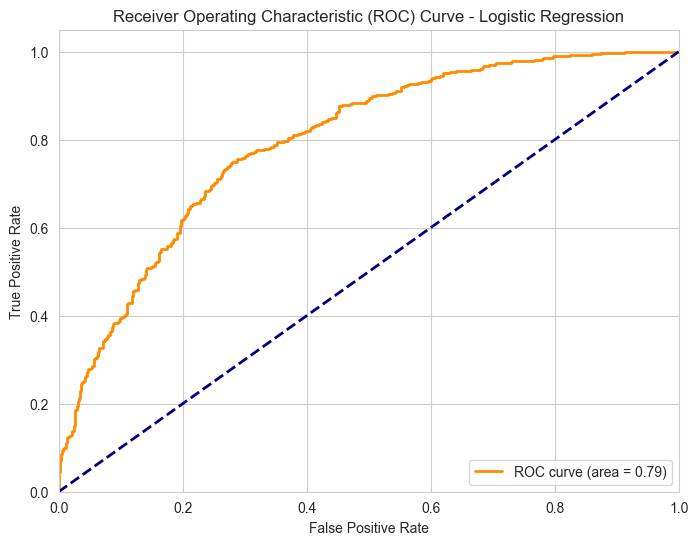


Training Random Forest...
Random Forest Metrics:
  Accuracy: 0.7298
  Precision: 0.7447
  Recall: 0.7955
  F1-Score: 0.7692
  ROC-AUC: 0.7818
  Confusion Matrix:
[[369 204]
 [153 595]]


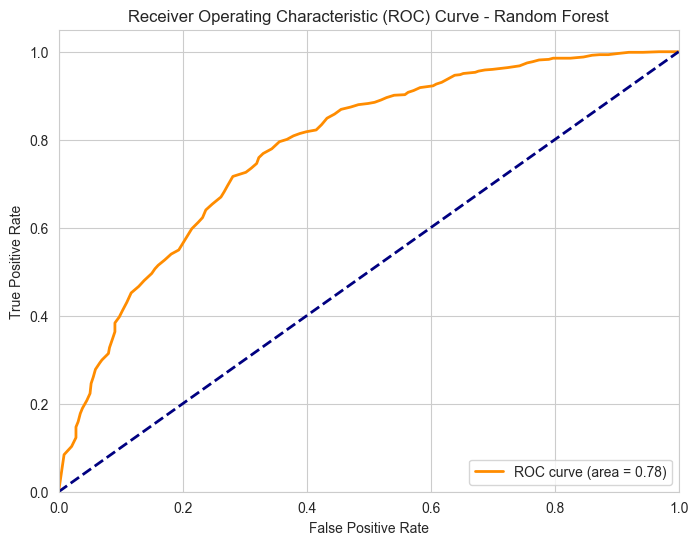


Training Gradient Boosting...
Gradient Boosting Metrics:
  Accuracy: 0.7517
  Precision: 0.7561
  Recall: 0.8289
  F1-Score: 0.7908
  ROC-AUC: 0.8120
  Confusion Matrix:
[[373 200]
 [128 620]]


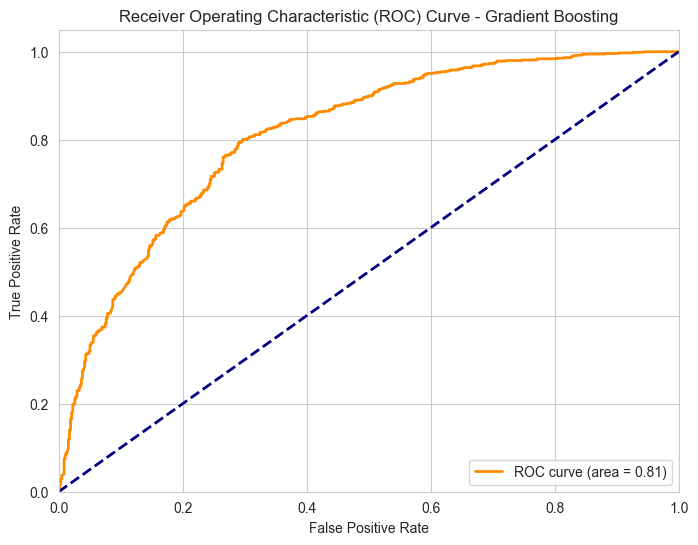

In [8]:
print("\n--- Model Training and Initial Evaluation ---")
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] # Probability of the positive class (churned)

    # Evaluate model performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Confusion Matrix': cm
    }

    print(f"{name} Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  Confusion Matrix:\n{cm}")

    # Plot ROC curve for each model
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()

Understanding Evaluation Metrics
In churn prediction, different metrics highlight different aspects of a model's performance. It's crucial to understand what each metric represents to choose the most appropriate one(s) for a given business problem.

Accuracy:

Definition: The proportion of correctly classified instances (both churned and non-churned) out of the total instances.

Consideration: While intuitive, Accuracy can be misleading, especially when dealing with imbalanced datasets (e.g., when the number of non-churned customers significantly outweighs churned customers). A model predicting all customers as non-churned might still achieve high accuracy if churn is rare.

Precision:

Definition: Of all customers predicted as churners, what percentage actually churned.

Formula: True Positives / (True Positives + False Positives)

Consideration: Important if minimizing "false alarms" (false positives) is key. For example, if a retention campaign is costly, you want to ensure that most customers you target are indeed at high risk of churning, rather than spending resources on loyal customers.

Recall (Sensitivity):

Definition: Of all actual churners, what percentage were correctly identified by the model.

Formula: True Positives / (True Positives + False Negatives)

Consideration: Crucial if identifying as many actual churners as possible (to prevent lost customers) is paramount. Missing a churner (false negative) means a lost opportunity for intervention.

F1-Score:

Definition: The harmonic mean of Precision and Recall. It provides a single score that balances both concerns.

Formula: 2 * (Precision * Recall) / (Precision + Recall)

Consideration: Particularly useful when there is an uneven class distribution, as it penalizes models that favor one class over another.

ROC-AUC (Receiver Operating Characteristic - Area Under the Curve):

Definition: Measures the classifier's ability to distinguish between classes across all possible classification thresholds. It plots the True Positive Rate (Recall) against the False Positive Rate at various threshold settings.

Consideration: A higher ROC-AUC value (closer to 1.0) indicates better model performance, signifying that the model can effectively separate the positive and negative classes. An AUC of 0.5 suggests no better than random guessing.

For this churn prediction project, Recall and ROC-AUC are often prioritized.

Recall helps ensure we capture a high proportion of actual churners, allowing the business to proactively intervene.

ROC-AUC provides a comprehensive measure of the model's overall discriminative power, independent of a specific classification threshold.

# --- 5. Hyperparameter Tuning Example (Gradient Boosting) ---

In [9]:
# We will now tune the Gradient Boosting Classifier, as it showed the highest initial ROC-AUC.
print("\n--- Hyperparameter Tuning (Example: Gradient Boosting) ---")

# Define a smaller, representative parameter grid for demonstration for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200], # Number of boosting stages
    'learning_rate': [0.05, 0.1], # Shrinkage factor
    'max_depth': [3, 5], # Max depth of individual estimators
    'subsample': [0.8, 1.0] # Fraction of samples for fitting the individual base learners
}

# Using the Gradient Boosting Classifier directly
gb_model = GradientBoostingClassifier(random_state=42)
grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb,
                                cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)

print(f"\nStarting GridSearchCV for Gradient Boosting (this might take a few minutes)...")
grid_search_gb.fit(X_train, y_train)

print(f"\nBest parameters for Gradient Boosting: {grid_search_gb.best_params_}")
print(f"Best ROC-AUC score on training set (CV): {grid_search_gb.best_score_:.4f}")


--- Hyperparameter Tuning (Example: Gradient Boosting) ---

Starting GridSearchCV for Gradient Boosting (this might take a few minutes)...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best parameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best ROC-AUC score on training set (CV): 0.7961


In [10]:
# Using the Random Forest Classifier directly (no scaler needed for tree-based models)
param_grid_rf = {
    'n_estimators': [100, 200, 300],         # number of trees
    'max_depth': [None, 10, 20, 30],         # depth of trees
    'min_samples_split': [2, 5, 10],         # split criteria
    'min_samples_leaf': [1, 2, 4],           # minimum samples per leaf
    'max_features': ['sqrt', 'log2'],        # number of features
    'bootstrap': [True, False]               # sampling method
}

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced') # 'balanced' handles class imbalance
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf,
                                cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)

print(f"\nStarting GridSearchCV for Random Forest (this might take a few minutes)...")
grid_search_rf.fit(X_train, y_train)

print(f"\nBest parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best ROC-AUC score on training set (CV): {grid_search_rf.best_score_:.4f}")

# Evaluate the best Random Forest model on the test set
best_rf_model = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)
y_proba_best_rf = best_rf_model.predict_proba(X_test)[:, 1]

print("\n--- Best Random Forest Model Performance on Test Set ---")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_best_rf):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_best_rf):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_best_rf):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_best_rf):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_proba_best_rf):.4f}")
print(f"  Confusion Matrix:\n{confusion_matrix(y_test, y_pred_best_rf)}")


Starting GridSearchCV for Random Forest (this might take a few minutes)...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits

Best parameters for Random Forest: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best ROC-AUC score on training set (CV): 0.7938

--- Best Random Forest Model Performance on Test Set ---
  Accuracy: 0.7449
  Precision: 0.7758
  Recall: 0.7727
  F1-Score: 0.7743
  ROC-AUC: 0.8122
  Confusion Matrix:
[[406 167]
 [170 578]]


In [11]:
# Evaluate the best Gradient Boosting model on the test set
best_gb_model = grid_search_gb.best_estimator_
y_pred_best_gb = best_gb_model.predict(X_test)
y_proba_best_gb = best_gb_model.predict_proba(X_test)[:, 1]

print("\n--- Best Gradient Boosting Model Performance on Test Set ---")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_best_gb):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_best_gb):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_best_gb):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_best_gb):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_proba_best_gb):.4f}")
print(f"  Confusion Matrix:\n{confusion_matrix(y_test, y_pred_best_gb)}")

# Update results with the tuned GB model (optional, but good for tracking)
results['Tuned Gradient Boosting'] = {
    'Accuracy': accuracy_score(y_test, y_pred_best_gb),
    'Precision': precision_score(y_test, y_pred_best_gb),
    'Recall': recall_score(y_test, y_pred_best_gb),
    'F1-Score': f1_score(y_test, y_pred_best_gb),
    'ROC-AUC': roc_auc_score(y_test, y_proba_best_gb),
    'Confusion Matrix': confusion_matrix(y_test, y_pred_best_gb)
}


--- Best Gradient Boosting Model Performance on Test Set ---
  Accuracy: 0.7517
  Precision: 0.7536
  Recall: 0.8342
  F1-Score: 0.7919
  ROC-AUC: 0.8121
  Confusion Matrix:
[[369 204]
 [124 624]]


# --- 6. Feature Importance Analysis (for Tree-based models) ---


--- Feature Importance Analysis ---

Top 10 Feature Importances (from Tuned Gradient Boosting):
                   Feature  Importance
2                  Recency    0.553570
1                Frequency    0.189671
0                 Monetary    0.175155
3                   Tenure    0.071545
8            Country_Other    0.002780
12     Country_Switzerland    0.001727
10           Country_Spain    0.001724
13  Country_United Kingdom    0.001191
6          Country_Germany    0.000879
9         Country_Portugal    0.000744


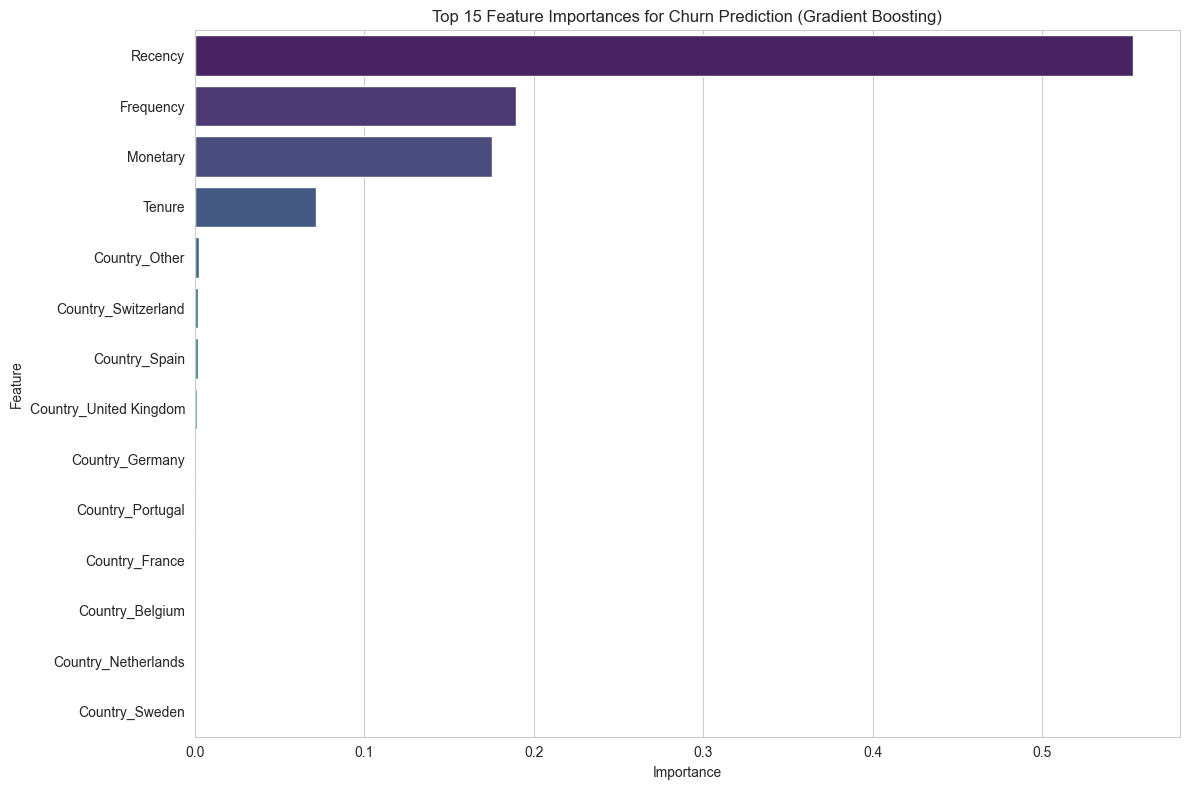

In [12]:
print("\n--- Feature Importance Analysis ---")
# Feature importance from the best Random Forest model
if hasattr(best_gb_model, 'feature_importances_'):
    importances = best_gb_model.feature_importances_
    feature_names = X.columns
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print("\nTop 10 Feature Importances (from Tuned Gradient Boosting):")
    print(feature_importance_df.head(10))

    # Visualize feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis',
                hue='Feature', legend=False) # Added hue and legend=False
    plt.title('Top 15 Feature Importances for Churn Prediction (Gradient Boosting)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("Feature importances not available for this model (e.g., Logistic Regression coefficients are different).")


# --- 7. Model Saving ---

In [13]:
# Save the best performing model (Tuned Gradient Boosting)
model_save_path = '../models/best_churn_model.joblib'
joblib.dump(best_gb_model, model_save_path)
print(f"\nBest performing model (Tuned Gradient Boosting) saved to: {model_save_path}")

print("\n--- Modeling & Evaluation Complete ---")


Best performing model (Tuned Gradient Boosting) saved to: ../models/best_churn_model.joblib

--- Modeling & Evaluation Complete ---
